In [1]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

from IPython.display import clear_output


In [2]:
languages = []
X = []
Y = []
data = []

with open('name2lang.txt', 'r') as f:
  for line in f:
    name, lang = line.split(',')
    if lang.strip() not in languages:
      languages.append(lang.strip())
    X.append(name.strip())
    Y.append(lang.strip())
    data.append((name.strip(), lang.strip()))

n_languages = len(languages)

In [3]:
print(data[0:10])

[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1, stratify = Y)

In [5]:
print(len(X_train), len(X_test))

16040 4010


### Encoding

In [6]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [7]:
n_letters

57

In [8]:
def name_rep(name):
  rep = torch.zeros(len(name), 1, n_letters)
  for index, letter in enumerate(name):
    pos = all_letters.find(letter)
    rep[index][0][pos] = 1
  return rep

In [9]:
def lang_rep(lang):
  return torch.tensor([languages.index(lang)], dtype = torch.long)

In [10]:
lang_rep("Portuguese")

tensor([0])

In [11]:
count = {}
for i in Y:
  if i not in count:
    count[i] = 1
  else:
    count[i] = count[i] + 1

print(count)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


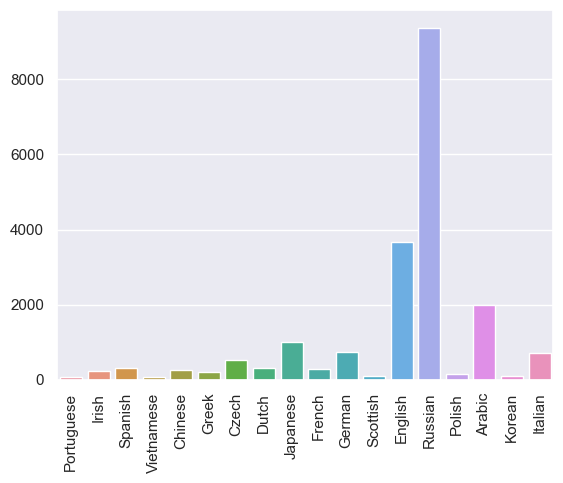

In [12]:
ax = sns.barplot(x = list(count.keys()), y = list(count.values()))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

In [13]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim= 1)

  def forward(self, input_, hidden):
    combined = torch.cat((input_, hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)

In [14]:
n_hidden = 128
net = RNN(n_letters, n_hidden, n_languages)

In [15]:
def infer(net, name):
  net.eval()
  name_ohe = name_rep(name)
  hidden = net.init_hidden()

  for i in range(name_ohe.size()[0]):
    output, hidden = net(name_ohe[i], hidden)

  return output


In [16]:
output = infer(net, 'Adam')
index = torch.argmax(output)
print(output, index)


tensor([[-2.8516, -2.8886, -2.9107, -2.8571, -2.8216, -2.8986, -2.9130, -3.0523,
         -2.8964, -2.9577, -2.9296, -2.8331, -2.8671, -2.8904, -2.8881, -2.8212,
         -2.8285, -2.9489]], grad_fn=<LogSoftmaxBackward0>) tensor(15)


### Evaluation

In [17]:
def dataloader(npoints, X_, y_):
  to_ret = []
  for i in range(npoints):
    index_ = np.random.randint(len(X_))
    name, lang = X_[index_], y_[index_]
    to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
  return to_ret

In [18]:
def eval(net, n_points, k, X_, y_):

  data_ = dataloader(n_points, X_, y_)
  correct = 0
  for name, language, name_ohe, lang_rep in data_:

    output = infer(net, name)
    val, indices = output.topk(k)

    if lang_rep in indices:
      correct += 1

  accuracy = correct / n_points
  return accuracy

In [19]:
eval(net, 1000, 3, X_test, y_test)

0.082

### Training

In [20]:
def train(net, opt, criterion, n_points):

  opt.zero_grad()
  total_loss = 0

  data_ = dataloader(n_points, X_train, y_train)

  for name, language, name_ohe, lang_rep in data_:
    hidden = net.init_hidden()

    for i in range(name_ohe.size()[0]):
      output, hidden = net(name_ohe[i], hidden)

    loss = criterion(output, lang_rep)
    loss.backward(retain_graph = True)

    total_loss += loss
  
  opt.step()
  return total_loss / n_points


In [21]:
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)

In [22]:
train(net, opt, criterion, 200)

tensor(2.8994, grad_fn=<DivBackward0>)

In [23]:
eval(net, 1000, 1, X_test, y_test)

0.449

In [24]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq = 5):
  criterion = nn.NLLLoss()
  opt = optim.SGD(net.parameters(), lr = lr, momentum = momentum)
  loss_arr = np.zeros(n_batches + 1)

  for i in range(n_batches):
    loss_arr[i+1] = (loss_arr[i] * i + train(net, opt, criterion, batch_size)) / (i + 1)                                              
    if i % display_freq == display_freq - 1:
      clear_output(wait = True)

      print(f"Iteration: {i}, Top-5: {eval(net, len(X_test), 5, X_test, y_test)}")
      plt.figure()
      plt.plot(loss_arr[1:i], '-+')
      plt.xlabel("Iteration")
      plt.ylabel("Loss")
      plt.show()
      print('\n\n')

Iteration: 99, Top-5: 0.9054862842892768


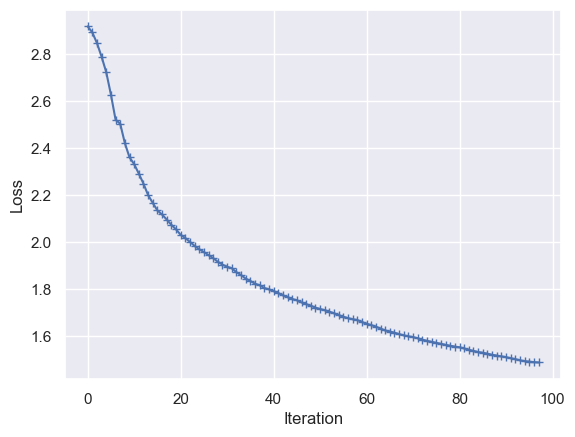

In [25]:
n_hidden = 128
net = RNN(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.0005, n_batches = 100, batch_size = 256)